# SDI calculation for HCP (Normal) Patient Data 

In [9]:
import os
import numpy as np
from scipy.linalg import eigh
import csv

def compute_structural_laplacian(A):
    D = np.diag(np.sum(A, axis=1))
    with np.errstate(divide='ignore'):
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1)))
    D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0
    L = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
    return L

def graph_spectral_phase_randomize(X, eigvecs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X_hat = X @ eigvecs  # project into graph spectral domain
    T, N = X_hat.shape
    X_surr = np.zeros_like(X_hat)

    for i in range(N):
        fft_coeff = np.fft.fft(X_hat[:, i])
        mag = np.abs(fft_coeff)
        phase = np.angle(fft_coeff)
        num_phases = len(fft_coeff)

        random_phases = np.random.uniform(0, 2*np.pi, num_phases // 2 - 1)
        new_phase = np.copy(phase)
        new_phase[1:num_phases//2] = random_phases
        new_phase[-(num_phases//2)+1:] = -random_phases[::-1]

        new_fft = mag * np.exp(1j * new_phase)
        X_surr[:, i] = np.fft.ifft(new_fft).real

    return X_surr @ eigvecs.T  # back-project into time domain

def compute_SDI_informed(A, X, num_surrogates=100, K_ratio=0.3, seed=None):
    # Preprocess functional data: demean and normalize each node timeseries
    X = X - X.mean(axis=0)
    X = X / (X.std(axis=0) + 1e-10)

    T, N = X.shape
    L = compute_structural_laplacian(A)
    eigvals, eigvecs = eigh(L)

    K = int(np.floor(N * K_ratio))
    if K == 0 or K == N:
        raise ValueError(f"Invalid K: {K} for N={N} and K_ratio={K_ratio}")

    Vlow, Vhigh = eigvecs[:, :K], eigvecs[:, K:]

    N_c_surr, N_d_surr = np.empty((N, num_surrogates)), np.empty((N, num_surrogates))

    for s in range(num_surrogates):
        X_surr = graph_spectral_phase_randomize(X, eigvecs, seed=seed+s)
        X_hat = X_surr @ eigvecs

        X_c = X_hat[:, :K] @ Vlow.T
        X_d = X_hat[:, K:] @ Vhigh.T

        for r in range(N):
            N_c_surr[r, s] = np.linalg.norm(X_c[:, r])
            N_d_surr[r, s] = np.linalg.norm(X_d[:, r])

    SDI = N_d_surr / (N_c_surr + 1e-10)
    mean_SDI = np.mean(SDI, axis=1)
    print(f"Informed SDI stats: mean={mean_SDI.mean():.4f}, std={mean_SDI.std():.4f}")
    return mean_SDI


def main(functional_dir, structural_dir, output_csv_path, num_surrogates=100, K_ratio=0.3, seed=42):
    func_files = {os.path.splitext(f)[0]: os.path.join(functional_dir, f)
                  for f in os.listdir(functional_dir) if f.endswith('.ts')}
    struct_files = {os.path.splitext(f)[0].replace('_5000', ''): os.path.join(structural_dir, f)
                    for f in os.listdir(structural_dir) if f.endswith('.sc')}

    common_patients = set(func_files.keys()) & set(struct_files.keys())
    print(f"Found {len(common_patients)} patients with matching data.")

    results = []
    max_nodes = 0

    for pid in sorted(common_patients):
        func_path = func_files[pid]
        struct_path = struct_files[pid]

        try:
            X = np.loadtxt(func_path)
            A = np.loadtxt(struct_path)

            if X.size == 0 or A.size == 0:
                print(f"Skipping {pid}: empty data")
                continue

            if len(A.shape) != 2 or A.shape[0] != A.shape[1]:
                print(f"Skipping {pid}: Structural matrix not square {A.shape}")
                continue

            if len(X.shape) != 2:
                print(f"Skipping {pid}: Functional data not 2D {X.shape}")
                continue

            T, N_f = X.shape
            N_s = A.shape[0]

            if N_f != N_s:
                if N_s > N_f:
                    A = A[:N_f, :N_f]
                    N_s = N_f
                    print(f"Truncated structural matrix for {pid} from {A.shape[0]} to {N_f} nodes")
                else:
                    print(f"Skipping {pid}: functional nodes > structural nodes (cannot truncate)")
                    continue

            N = min(N_f, N_s)
            if N == 0:
                print(f"Skipping {pid}: zero dimension after truncation")
                continue

            X = X[:, :N]
            A = A[:N, :N]

            sdi = compute_SDI_informed(A, X, num_surrogates=num_surrogates, K_ratio=K_ratio, seed=seed)
            sdi = np.log2(sdi + 1e-10)  # log transform, avoid log(0)

            results.append((pid, sdi))
            max_nodes = max(max_nodes, len(sdi))

        except Exception as e:
            print(f"Error processing {pid}: {e}")

    with open(output_csv_path, 'w', newline='') as f_out:
        writer = csv.writer(f_out)
        header = ['PatientID'] + [f'SDI_Node_{i+1}' for i in range(max_nodes)]
        writer.writerow(header)

        for pid, sdi in results:
            row = [pid] + list(sdi) + [np.nan]*(max_nodes - len(sdi))
            writer.writerow(row)

    print(f"Saved all SDI results to {output_csv_path}")


if __name__ == "__main__":
    functional_dir = "/Users/arnavkarnik/Documents/Brain-Structure-Function-Coupling-and-Graph-Laplacians-in-Neuroimaging-for-Disease-Characterization/REST2_RL"
    structural_dir = "/Users/arnavkarnik/Documents/Brain-Structure-Function-Coupling-and-Graph-Laplacians-in-Neuroimaging-for-Disease-Characterization/SC_yeo_100"
    output_csv_path = "/Users/arnavkarnik/Documents/Brain-Structure-Function-Coupling-and-Graph-Laplacians-in-Neuroimaging-for-Disease-Characterization/SDI_results/all_patients_SDI_informed.csv"
    main(functional_dir, structural_dir, output_csv_path, num_surrogates=100, K_ratio=0.3, seed=42)

Found 95 patients with matching data.
Truncated structural matrix for 100307 from 89 to 89 nodes
Informed SDI stats: mean=1.2339, std=0.1763
Truncated structural matrix for 100408 from 89 to 89 nodes
Informed SDI stats: mean=0.8428, std=0.1572
Truncated structural matrix for 101107 from 89 to 89 nodes
Informed SDI stats: mean=0.9312, std=0.1961
Truncated structural matrix for 101309 from 89 to 89 nodes
Informed SDI stats: mean=1.0842, std=0.1967
Truncated structural matrix for 101915 from 89 to 89 nodes
Informed SDI stats: mean=1.0725, std=0.2640
Truncated structural matrix for 103111 from 89 to 89 nodes
Informed SDI stats: mean=1.1736, std=0.1920
Truncated structural matrix for 103414 from 89 to 89 nodes
Informed SDI stats: mean=1.2588, std=0.2038
Truncated structural matrix for 103818 from 89 to 89 nodes
Informed SDI stats: mean=1.0021, std=0.1820
Truncated structural matrix for 105014 from 17 to 17 nodes
Informed SDI stats: mean=1.3065, std=0.2505
Truncated structural matrix for 105

/var/folders/0b/d5vghlcn39jb_kt0c4whkzcr0000gn/T/ipykernel_5517/1696527523.py:88: UserWarning: loadtxt: input contained no data: "/Users/arnavkarnik/Documents/Brain-Structure-Function-Coupling-and-Graph-Laplacians-in-Neuroimaging-for-Disease-Characterization/REST2_RL/163129.ts"
  X = np.loadtxt(func_path)


Informed SDI stats: mean=1.0063, std=0.1637
Truncated structural matrix for 178950 from 89 to 89 nodes
Informed SDI stats: mean=1.1212, std=0.1549
Truncated structural matrix for 188347 from 89 to 89 nodes
Informed SDI stats: mean=0.9201, std=0.1714
Truncated structural matrix for 189450 from 89 to 89 nodes
Informed SDI stats: mean=1.0324, std=0.1620
Truncated structural matrix for 190031 from 89 to 89 nodes
Informed SDI stats: mean=0.9593, std=0.1816
Truncated structural matrix for 192540 from 89 to 89 nodes
Informed SDI stats: mean=0.8393, std=0.1624
Truncated structural matrix for 196750 from 89 to 89 nodes
Informed SDI stats: mean=1.0057, std=0.2074
Truncated structural matrix for 198451 from 89 to 89 nodes
Informed SDI stats: mean=1.0791, std=0.1665
Truncated structural matrix for 199655 from 89 to 89 nodes
Informed SDI stats: mean=1.0806, std=0.1941
Truncated structural matrix for 201111 from 89 to 89 nodes
Informed SDI stats: mean=1.0203, std=0.1782
Truncated structural matrix f

/var/folders/0b/d5vghlcn39jb_kt0c4whkzcr0000gn/T/ipykernel_5517/1696527523.py:88: UserWarning: loadtxt: input contained no data: "/Users/arnavkarnik/Documents/Brain-Structure-Function-Coupling-and-Graph-Laplacians-in-Neuroimaging-for-Disease-Characterization/REST2_RL/214423.ts"
  X = np.loadtxt(func_path)


Informed SDI stats: mean=1.0512, std=0.1720
Truncated structural matrix for 239944 from 89 to 89 nodes
Informed SDI stats: mean=1.3116, std=0.1751
Truncated structural matrix for 245333 from 89 to 89 nodes
Informed SDI stats: mean=1.3067, std=0.2087
Truncated structural matrix for 280739 from 89 to 89 nodes
Informed SDI stats: mean=1.3565, std=0.1772
Truncated structural matrix for 298051 from 89 to 89 nodes
Informed SDI stats: mean=1.0471, std=0.2012
Truncated structural matrix for 366446 from 89 to 89 nodes
Informed SDI stats: mean=1.0081, std=0.1849
Truncated structural matrix for 397760 from 89 to 89 nodes
Informed SDI stats: mean=1.2453, std=0.1954
Truncated structural matrix for 414229 from 89 to 89 nodes
Informed SDI stats: mean=0.9356, std=0.1811
Truncated structural matrix for 499566 from 89 to 89 nodes
Informed SDI stats: mean=1.0363, std=0.2010
Truncated structural matrix for 654754 from 89 to 89 nodes
Informed SDI stats: mean=1.1620, std=0.1912
Truncated structural matrix f

Found 95 patients with matching data.
Patient 100307: Functional shape (1200, 89), Structural shape (100, 100)
Plotting matrices for patient 100307


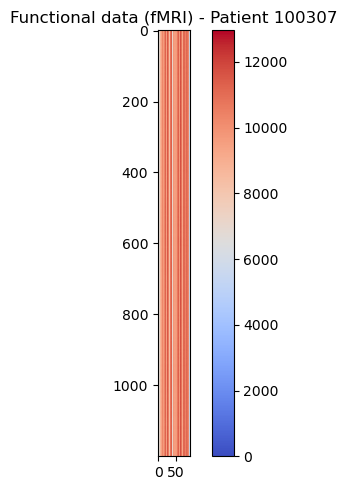

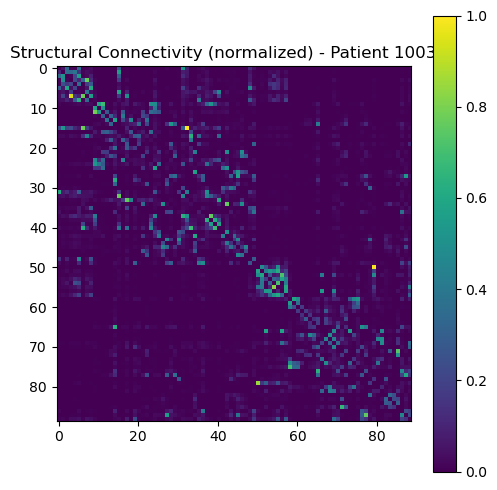

Patient 100408: Functional shape (1200, 89), Structural shape (100, 100)
Plotting matrices for patient 100408


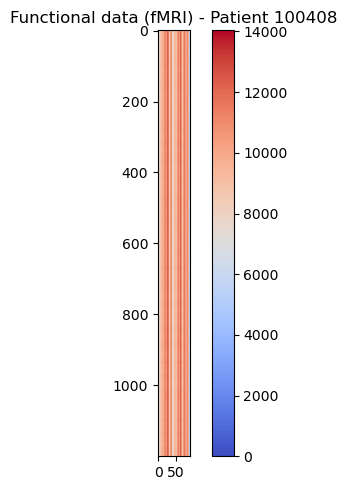

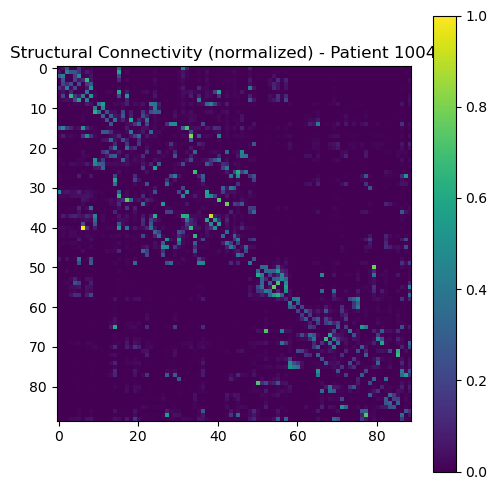

Patient 101107: Functional shape (1200, 89), Structural shape (100, 100)
Plotting matrices for patient 101107


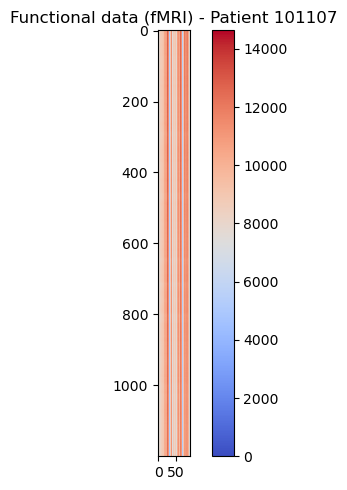

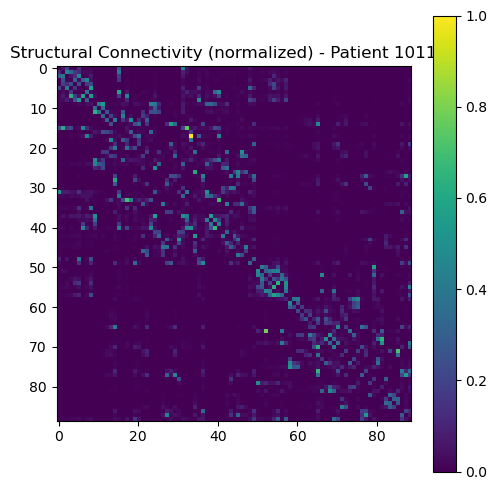

Patient 101309: Functional shape (1200, 89), Structural shape (100, 100)
Patient 101915: Functional shape (1200, 89), Structural shape (100, 100)
Patient 103111: Functional shape (1200, 89), Structural shape (100, 100)
Patient 103414: Functional shape (1200, 89), Structural shape (100, 100)
Patient 103818: Functional shape (1200, 89), Structural shape (100, 100)
Patient 105014: Functional shape (1200, 17), Structural shape (100, 100)
Patient 105115: Functional shape (1200, 89), Structural shape (100, 100)
Patient 106016: Functional shape (1200, 89), Structural shape (100, 100)
Patient 108828: Functional shape (1200, 89), Structural shape (100, 100)
Patient 110411: Functional shape (1200, 89), Structural shape (100, 100)
Patient 111312: Functional shape (1200, 89), Structural shape (100, 100)
Patient 111716: Functional shape (1200, 89), Structural shape (100, 100)
Patient 113619: Functional shape (1200, 89), Structural shape (100, 100)
Patient 113922: Functional shape (1200, 89), Struct

/var/folders/0b/d5vghlcn39jb_kt0c4whkzcr0000gn/T/ipykernel_5517/675329308.py:126: UserWarning: loadtxt: input contained no data: "/Users/arnavkarnik/Documents/Brain-Structure-Function-Coupling-and-Graph-Laplacians-in-Neuroimaging-for-Disease-Characterization/REST2_RL/163129.ts"
  X = np.loadtxt(func_path)


Patient 163129: Functional shape (0,), Structural shape (100, 100)
Skipping 163129: empty data
Patient 176542: Functional shape (1200, 89), Structural shape (100, 100)
Patient 178950: Functional shape (1200, 89), Structural shape (100, 100)
Patient 188347: Functional shape (1200, 89), Structural shape (100, 100)
Patient 189450: Functional shape (1200, 89), Structural shape (100, 100)
Patient 190031: Functional shape (1200, 89), Structural shape (100, 100)
Patient 192540: Functional shape (1200, 89), Structural shape (100, 100)
Patient 196750: Functional shape (1200, 89), Structural shape (100, 100)
Patient 198451: Functional shape (1200, 89), Structural shape (100, 100)
Patient 199655: Functional shape (1200, 89), Structural shape (100, 100)
Patient 201111: Functional shape (1200, 89), Structural shape (100, 100)
Patient 208226: Functional shape (1200, 89), Structural shape (100, 100)
Patient 211417: Functional shape (1200, 89), Structural shape (100, 100)
Patient 211720: Functional sh

/var/folders/0b/d5vghlcn39jb_kt0c4whkzcr0000gn/T/ipykernel_5517/675329308.py:126: UserWarning: loadtxt: input contained no data: "/Users/arnavkarnik/Documents/Brain-Structure-Function-Coupling-and-Graph-Laplacians-in-Neuroimaging-for-Disease-Characterization/REST2_RL/214423.ts"
  X = np.loadtxt(func_path)


Patient 214423: Functional shape (0,), Structural shape (100, 100)
Skipping 214423: empty data
Patient 221319: Functional shape (1200, 89), Structural shape (100, 100)
Patient 239944: Functional shape (1200, 89), Structural shape (100, 100)
Patient 245333: Functional shape (1200, 89), Structural shape (100, 100)
Patient 280739: Functional shape (1200, 89), Structural shape (100, 100)
Patient 298051: Functional shape (1200, 89), Structural shape (100, 100)
Patient 366446: Functional shape (1200, 89), Structural shape (100, 100)
Patient 397760: Functional shape (1200, 89), Structural shape (100, 100)
Patient 414229: Functional shape (1200, 89), Structural shape (100, 100)
Patient 499566: Functional shape (1200, 89), Structural shape (100, 100)
Patient 654754: Functional shape (1200, 89), Structural shape (100, 100)
Patient 672756: Functional shape (1200, 89), Structural shape (100, 100)
Patient 751348: Functional shape (1200, 89), Structural shape (100, 100)
Patient 756055: Functional sh

In [10]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import csv

def plot_matrix(mat, title, cmap='viridis'):
    plt.figure(figsize=(5, 5))
    plt.imshow(mat, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

def normalize_matrix(mat):
    min_val = np.min(mat)
    max_val = np.max(mat)
    if max_val - min_val == 0:
        return np.zeros_like(mat)
    return (mat - min_val) / (max_val - min_val)

def compute_structural_laplacian(A):
    D = np.diag(np.sum(A, axis=1))
    with np.errstate(divide='ignore'):
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1)))
    D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0
    L = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
    return L

def graph_spectral_phase_randomize(X, eigvecs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X_hat = X @ eigvecs  # project into graph spectral domain
    T, N = X_hat.shape
    X_surr = np.zeros_like(X_hat)

    for i in range(N):
        fft_coeff = np.fft.fft(X_hat[:, i])
        mag = np.abs(fft_coeff)
        phase = np.angle(fft_coeff)
        num_phases = len(fft_coeff)

        # randomize phases symmetrically except DC and Nyquist (if even)
        random_phases = np.random.uniform(0, 2*np.pi, num_phases // 2 - 1)
        new_phase = np.copy(phase)
        new_phase[1:num_phases//2] = random_phases
        new_phase[-(num_phases//2)+1:] = -random_phases[::-1]

        new_fft = mag * np.exp(1j * new_phase)
        X_surr[:, i] = np.fft.ifft(new_fft).real

    return X_surr @ eigvecs.T  # back-project into time domain

def energy_based_split(eigvals, energy_threshold=0.5):
    """
    Implements energy-based eigenvector split following Preti and Van De Ville.
    Splits eigenvectors into low and high frequency sets such that
    cumulative energy of low freq <= threshold.
    """
    total_energy = np.sum(eigvals)
    cum_energy = np.cumsum(eigvals)
    K = np.searchsorted(cum_energy / total_energy, energy_threshold) + 1
    return K

def compute_SDI_informed(A, X, num_surrogates=100, energy_threshold=0.5, seed=None):
    # Normalize functional data (demean + std)
    X = X - X.mean(axis=0)
    X = X / (X.std(axis=0) + 1e-10)

    T, N = X.shape
    L = compute_structural_laplacian(A)
    eigvals, eigvecs = eigh(L)

    # Energy-based eigenvector split
    K = energy_based_split(eigvals, energy_threshold=energy_threshold)
    # print(f"Energy split at K={K} (energy threshold={energy_threshold})")

    Vlow, Vhigh = eigvecs[:, :K], eigvecs[:, K:]

    N_c_surr, N_d_surr = np.empty((N, num_surrogates)), np.empty((N, num_surrogates))

    for s in range(num_surrogates):
        X_surr = graph_spectral_phase_randomize(X, eigvecs, seed=seed+s if seed else None)
        X_hat = X_surr @ eigvecs

        X_c = X_hat[:, :K] @ Vlow.T
        X_d = X_hat[:, K:] @ Vhigh.T

        for r in range(N):
            N_c_surr[r, s] = np.linalg.norm(X_c[:, r])
            N_d_surr[r, s] = np.linalg.norm(X_d[:, r])

    SDI = N_d_surr / (N_c_surr + 1e-10)
    mean_SDI = np.mean(SDI, axis=1)

    # Min-max normalize SDI between 0 and 1 per patient
    min_val, max_val = np.min(mean_SDI), np.max(mean_SDI)
    if max_val - min_val > 0:
        mean_SDI_norm = (mean_SDI - min_val) / (max_val - min_val)
    else:
        mean_SDI_norm = np.zeros_like(mean_SDI)

    return mean_SDI_norm, K

def main(functional_dir, structural_dir, output_csv_path, num_surrogates=100, energy_threshold=0.5, seed=42):
    func_files = {os.path.splitext(f)[0]: os.path.join(functional_dir, f)
                  for f in os.listdir(functional_dir) if f.endswith('.ts')}
    struct_files = {os.path.splitext(f)[0].replace('_5000', ''): os.path.join(structural_dir, f)
                    for f in os.listdir(structural_dir) if f.endswith('.sc')}

    common_patients = set(func_files.keys()) & set(struct_files.keys())
    print(f"Found {len(common_patients)} patients with matching data.")

    results = []
    max_nodes = 0

    # For plotting examples
    example_plotted = 0
    max_examples = 3

    for pid in sorted(common_patients):
        func_path = func_files[pid]
        struct_path = struct_files[pid]

        try:
            X = np.loadtxt(func_path)
            A = np.loadtxt(struct_path)

            print(f"Patient {pid}: Functional shape {X.shape}, Structural shape {A.shape}")

            if X.size == 0 or A.size == 0:
                print(f"Skipping {pid}: empty data")
                continue

            if len(A.shape) != 2 or A.shape[0] != A.shape[1]:
                print(f"Skipping {pid}: Structural matrix not square {A.shape}")
                continue

            if len(X.shape) != 2:
                print(f"Skipping {pid}: Functional data not 2D {X.shape}")
                continue

            T, N_f = X.shape
            N_s = A.shape[0]

            # Truncate to min dimension to fix mismatch
            N = min(N_f, N_s)
            if N == 0:
                print(f"Skipping {pid}: zero dimension after truncation")
                continue

            # Truncate matrices
            X = X[:, :N]
            A = A[:N, :N]

            # Normalize structural matrix between 0 and 1
            A_norm = normalize_matrix(A)

            # Plot first few patients
            if example_plotted < max_examples:
                print(f"Plotting matrices for patient {pid}")
                plot_matrix(X, f"Functional data (fMRI) - Patient {pid}", cmap='coolwarm')
                plot_matrix(A_norm, f"Structural Connectivity (normalized) - Patient {pid}")
                example_plotted += 1

            sdi_norm, K = compute_SDI_informed(A_norm, X, num_surrogates=num_surrogates,
                                              energy_threshold=energy_threshold, seed=seed)

            results.append((pid, sdi_norm))
            max_nodes = max(max_nodes, len(sdi_norm))

        except Exception as e:
            print(f"Error processing {pid}: {e}")

    # Save results to CSV
    with open(output_csv_path, 'w', newline='') as f_out:
        writer = csv.writer(f_out)
        header = ['PatientID'] + [f'SDI_Node_{i+1}' for i in range(max_nodes)]
        writer.writerow(header)

        for pid, sdi in results:
            row = [pid] + list(sdi) + [np.nan]*(max_nodes - len(sdi))
            writer.writerow(row)

    print(f"Saved all SDI results to {output_csv_path}")

if __name__ == "__main__":
    functional_dir = "/Users/arnavkarnik/Documents/Brain-Structure-Function-Coupling-and-Graph-Laplacians-in-Neuroimaging-for-Disease-Characterization/REST2_RL"
    structural_dir = "/Users/arnavkarnik/Documents/Brain-Structure-Function-Coupling-and-Graph-Laplacians-in-Neuroimaging-for-Disease-Characterization/SC_yeo_100"
    output_csv_path = "/Users/arnavkarnik/Documents/Brain-Structure-Function-Coupling-and-Graph-Laplacians-in-Neuroimaging-for-Disease-Characterization/SDI_results/all_patients_SDI_informed_normalized.csv"

    main(functional_dir, structural_dir, output_csv_path,
         num_surrogates=100,
         energy_threshold=0.5,
         seed=42)


Found 95 patients with matching data.
Patient 100307: Functional shape (1200, 89), Structural shape (100, 100)
Plotting matrices for patient 100307


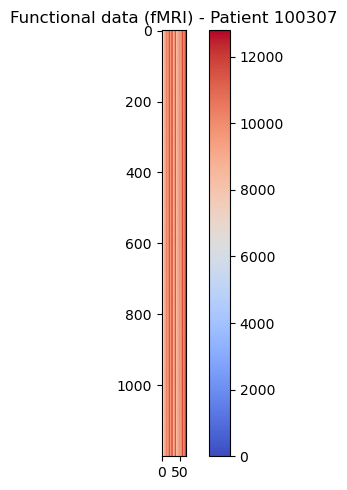

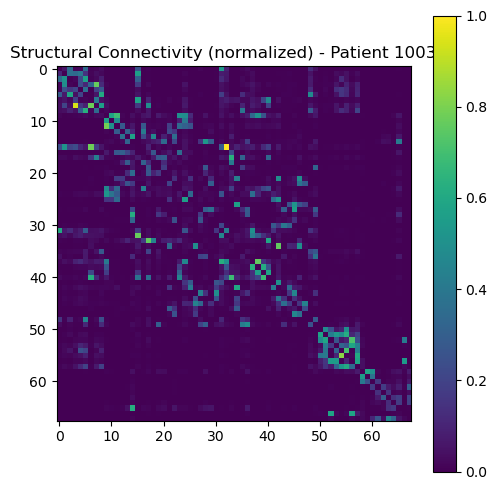

Patient 100408: Functional shape (1200, 89), Structural shape (100, 100)
Plotting matrices for patient 100408


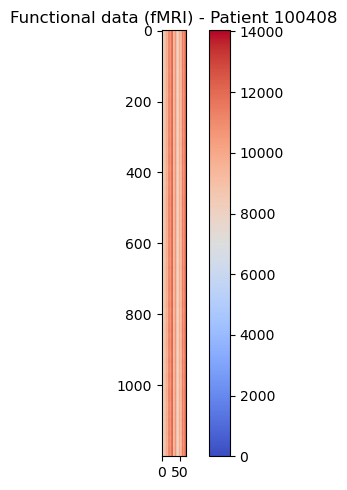

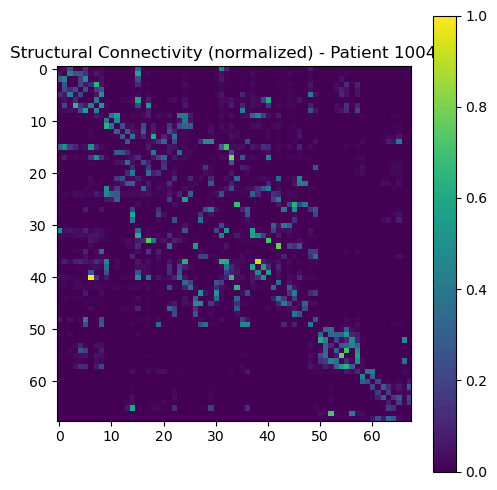

Patient 101107: Functional shape (1200, 89), Structural shape (100, 100)
Plotting matrices for patient 101107


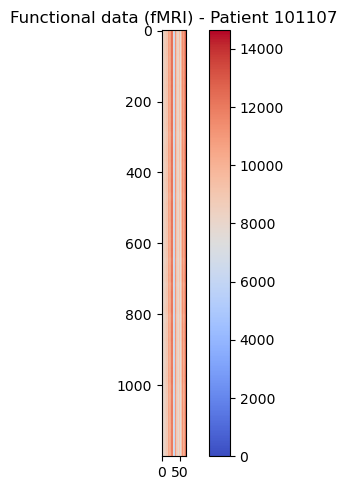

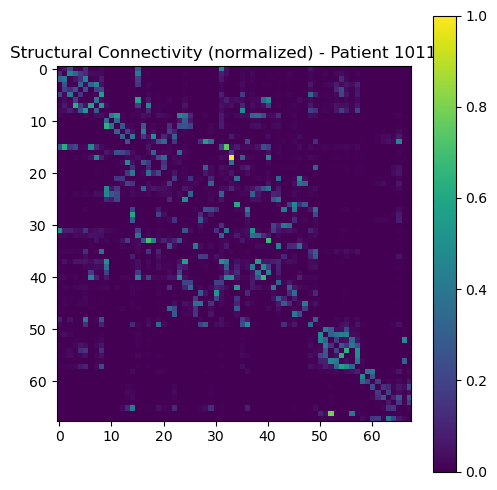

Patient 101309: Functional shape (1200, 89), Structural shape (100, 100)
Patient 101915: Functional shape (1200, 89), Structural shape (100, 100)
Patient 103111: Functional shape (1200, 89), Structural shape (100, 100)
Patient 103414: Functional shape (1200, 89), Structural shape (100, 100)
Patient 103818: Functional shape (1200, 89), Structural shape (100, 100)
Patient 105014: Functional shape (1200, 17), Structural shape (100, 100)
Patient 105115: Functional shape (1200, 89), Structural shape (100, 100)
Patient 106016: Functional shape (1200, 89), Structural shape (100, 100)
Patient 108828: Functional shape (1200, 89), Structural shape (100, 100)
Patient 110411: Functional shape (1200, 89), Structural shape (100, 100)
Patient 111312: Functional shape (1200, 89), Structural shape (100, 100)
Patient 111716: Functional shape (1200, 89), Structural shape (100, 100)
Patient 113619: Functional shape (1200, 89), Structural shape (100, 100)
Patient 113922: Functional shape (1200, 89), Struct

/var/folders/0b/d5vghlcn39jb_kt0c4whkzcr0000gn/T/ipykernel_5517/2645753609.py:126: UserWarning: loadtxt: input contained no data: "/Users/arnavkarnik/Documents/Classification/REST2_RL/163129.ts"
  X = np.loadtxt(func_path)


Patient 163129: Functional shape (0,), Structural shape (100, 100)
Skipping 163129: empty data
Patient 176542: Functional shape (1200, 89), Structural shape (100, 100)
Patient 178950: Functional shape (1200, 89), Structural shape (100, 100)
Patient 188347: Functional shape (1200, 89), Structural shape (100, 100)
Patient 189450: Functional shape (1200, 89), Structural shape (100, 100)
Patient 190031: Functional shape (1200, 89), Structural shape (100, 100)
Patient 192540: Functional shape (1200, 89), Structural shape (100, 100)
Patient 196750: Functional shape (1200, 89), Structural shape (100, 100)
Patient 198451: Functional shape (1200, 89), Structural shape (100, 100)
Patient 199655: Functional shape (1200, 89), Structural shape (100, 100)
Patient 201111: Functional shape (1200, 89), Structural shape (100, 100)
Patient 208226: Functional shape (1200, 89), Structural shape (100, 100)
Patient 211417: Functional shape (1200, 89), Structural shape (100, 100)
Patient 211720: Functional sh

/var/folders/0b/d5vghlcn39jb_kt0c4whkzcr0000gn/T/ipykernel_5517/2645753609.py:126: UserWarning: loadtxt: input contained no data: "/Users/arnavkarnik/Documents/Classification/REST2_RL/214423.ts"
  X = np.loadtxt(func_path)


Patient 214423: Functional shape (0,), Structural shape (100, 100)
Skipping 214423: empty data
Patient 221319: Functional shape (1200, 89), Structural shape (100, 100)
Patient 239944: Functional shape (1200, 89), Structural shape (100, 100)
Patient 245333: Functional shape (1200, 89), Structural shape (100, 100)
Patient 280739: Functional shape (1200, 89), Structural shape (100, 100)
Patient 298051: Functional shape (1200, 89), Structural shape (100, 100)
Patient 366446: Functional shape (1200, 89), Structural shape (100, 100)
Patient 397760: Functional shape (1200, 89), Structural shape (100, 100)
Patient 414229: Functional shape (1200, 89), Structural shape (100, 100)
Patient 499566: Functional shape (1200, 89), Structural shape (100, 100)
Patient 654754: Functional shape (1200, 89), Structural shape (100, 100)
Patient 672756: Functional shape (1200, 89), Structural shape (100, 100)
Patient 751348: Functional shape (1200, 89), Structural shape (100, 100)
Patient 756055: Functional sh

In [11]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import csv

def plot_matrix(mat, title, cmap='viridis'):
    plt.figure(figsize=(5, 5))
    plt.imshow(mat, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

def normalize_matrix(mat):
    min_val = np.min(mat)
    max_val = np.max(mat)
    if max_val - min_val == 0:
        return np.zeros_like(mat)
    return (mat - min_val) / (max_val - min_val)

def compute_structural_laplacian(A):
    D = np.diag(np.sum(A, axis=1))
    with np.errstate(divide='ignore'):
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.sum(A, axis=1)))
    D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0
    L = np.eye(A.shape[0]) - D_inv_sqrt @ A @ D_inv_sqrt
    return L

def graph_spectral_phase_randomize(X, eigvecs, seed=None):
    if seed is not None:
        np.random.seed(seed)
    X_hat = X @ eigvecs  # project into graph spectral domain
    T, N = X_hat.shape
    X_surr = np.zeros_like(X_hat)

    for i in range(N):
        fft_coeff = np.fft.fft(X_hat[:, i])
        mag = np.abs(fft_coeff)
        phase = np.angle(fft_coeff)
        num_phases = len(fft_coeff)

        # randomize phases symmetrically except DC and Nyquist (if even)
        random_phases = np.random.uniform(0, 2*np.pi, num_phases // 2 - 1)
        new_phase = np.copy(phase)
        new_phase[1:num_phases//2] = random_phases
        new_phase[-(num_phases//2)+1:] = -random_phases[::-1]

        new_fft = mag * np.exp(1j * new_phase)
        X_surr[:, i] = np.fft.ifft(new_fft).real

    return X_surr @ eigvecs.T  # back-project into time domain

def energy_based_split(eigvals, energy_threshold=0.5):
    """
    Implements energy-based eigenvector split following Preti and Van De Ville.
    Splits eigenvectors into low and high frequency sets such that
    cumulative energy of low freq <= threshold.
    """
    total_energy = np.sum(eigvals)
    cum_energy = np.cumsum(eigvals)
    K = np.searchsorted(cum_energy / total_energy, energy_threshold) + 1
    return K

def compute_SDI_informed(A, X, num_surrogates=100, energy_threshold=0.5, seed=None):
    # Normalize functional data (demean + std)
    X = X - X.mean(axis=0)
    X = X / (X.std(axis=0) + 1e-10)

    T, N = X.shape
    L = compute_structural_laplacian(A)
    eigvals, eigvecs = eigh(L)

    # Energy-based eigenvector split
    K = energy_based_split(eigvals, energy_threshold=energy_threshold)
    # print(f"Energy split at K={K} (energy threshold={energy_threshold})")

    Vlow, Vhigh = eigvecs[:, :K], eigvecs[:, K:]

    N_c_surr, N_d_surr = np.empty((N, num_surrogates)), np.empty((N, num_surrogates))

    for s in range(num_surrogates):
        X_surr = graph_spectral_phase_randomize(X, eigvecs, seed=seed+s if seed else None)
        X_hat = X_surr @ eigvecs

        X_c = X_hat[:, :K] @ Vlow.T
        X_d = X_hat[:, K:] @ Vhigh.T

        for r in range(N):
            N_c_surr[r, s] = np.linalg.norm(X_c[:, r])
            N_d_surr[r, s] = np.linalg.norm(X_d[:, r])

    SDI = N_d_surr / (N_c_surr + 1e-10)
    mean_SDI = np.mean(SDI, axis=1)

    # Min-max normalize SDI between 0 and 1 per patient
    min_val, max_val = np.min(mean_SDI), np.max(mean_SDI)
    if max_val - min_val > 0:
        mean_SDI_norm = (mean_SDI - min_val) / (max_val - min_val)
    else:
        mean_SDI_norm = np.zeros_like(mean_SDI)

    return mean_SDI_norm, K

def main(functional_dir, structural_dir, output_csv_path, num_surrogates=100, energy_threshold=0.5, seed=42):
    func_files = {os.path.splitext(f)[0]: os.path.join(functional_dir, f)
                  for f in os.listdir(functional_dir) if f.endswith('.ts')}
    struct_files = {os.path.splitext(f)[0].replace('_5000', ''): os.path.join(structural_dir, f)
                    for f in os.listdir(structural_dir) if f.endswith('.sc')}

    common_patients = set(func_files.keys()) & set(struct_files.keys())
    print(f"Found {len(common_patients)} patients with matching data.")

    results = []
    max_nodes = 0

    # For plotting examples
    example_plotted = 0
    max_examples = 3

    for pid in sorted(common_patients):
        func_path = func_files[pid]
        struct_path = struct_files[pid]

        try:
            X = np.loadtxt(func_path)
            A = np.loadtxt(struct_path)

            print(f"Patient {pid}: Functional shape {X.shape}, Structural shape {A.shape}")

            if X.size == 0 or A.size == 0:
                print(f"Skipping {pid}: empty data")
                continue

            if len(A.shape) != 2 or A.shape[0] != A.shape[1]:
                print(f"Skipping {pid}: Structural matrix not square {A.shape}")
                continue

            if len(X.shape) != 2:
                print(f"Skipping {pid}: Functional data not 2D {X.shape}")
                continue

            T, N_f = X.shape
            N_s = A.shape[0]

            # Truncate to max 68 nodes or smaller dimension to fix mismatch
            N = min(68, N_f, N_s)
            if N == 0:
                print(f"Skipping {pid}: zero dimension after truncation")
                continue

            # Truncate matrices
            X = X[:, :N]
            A = A[:N, :N]

            # Normalize structural matrix between 0 and 1
            A_norm = normalize_matrix(A)

            # Plot first few patients
            if example_plotted < max_examples:
                print(f"Plotting matrices for patient {pid}")
                plot_matrix(X, f"Functional data (fMRI) - Patient {pid}", cmap='coolwarm')
                plot_matrix(A_norm, f"Structural Connectivity (normalized) - Patient {pid}")
                example_plotted += 1

            sdi_norm, K = compute_SDI_informed(A_norm, X, num_surrogates=num_surrogates,
                                              energy_threshold=energy_threshold, seed=seed)

            results.append((pid, sdi_norm))
            max_nodes = max(max_nodes, len(sdi_norm))

        except Exception as e:
            print(f"Error processing {pid}: {e}")

    # Save results to CSV
    with open(output_csv_path, 'w', newline='') as f_out:
        writer = csv.writer(f_out)
        header = ['PatientID'] + [f'SDI_Node_{i+1}' for i in range(max_nodes)]
        writer.writerow(header)

        for pid, sdi in results:
            row = [pid] + list(sdi) + [np.nan]*(max_nodes - len(sdi))
            writer.writerow(row)

    print(f"Saved all SDI results to {output_csv_path}")

if __name__ == "__main__":
    functional_dir = "/Users/arnavkarnik/Documents/Classification/REST2_RL"
    structural_dir = "/Users/arnavkarnik/Documents/Classification/SC_yeo_100"
    output_csv_path = "/Users/arnavkarnik/Documents/Classification/results/all_patients_SDI_informed_normalized_hcp.csv"

    main(functional_dir, structural_dir, output_csv_path,
         num_surrogates=100,
         energy_threshold=0.5,
         seed=42)


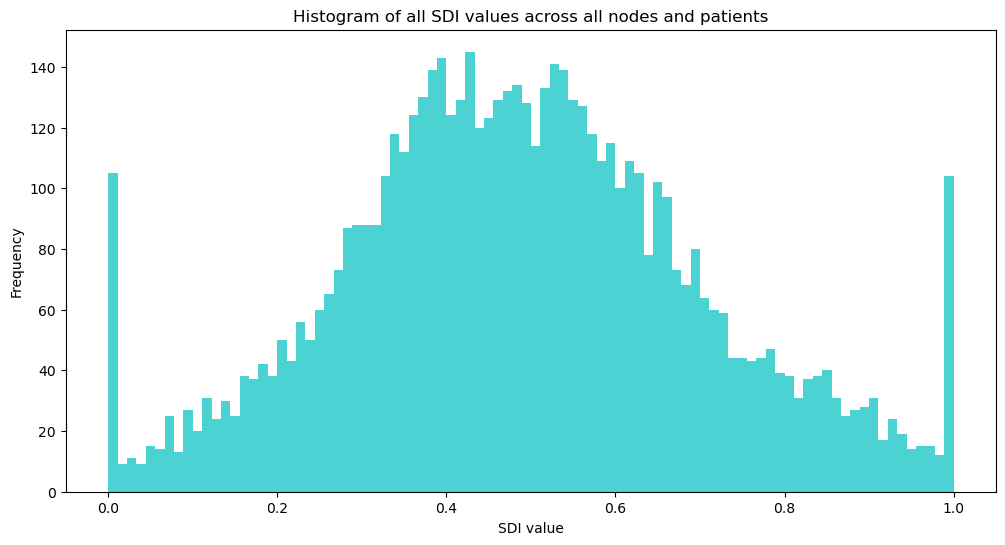

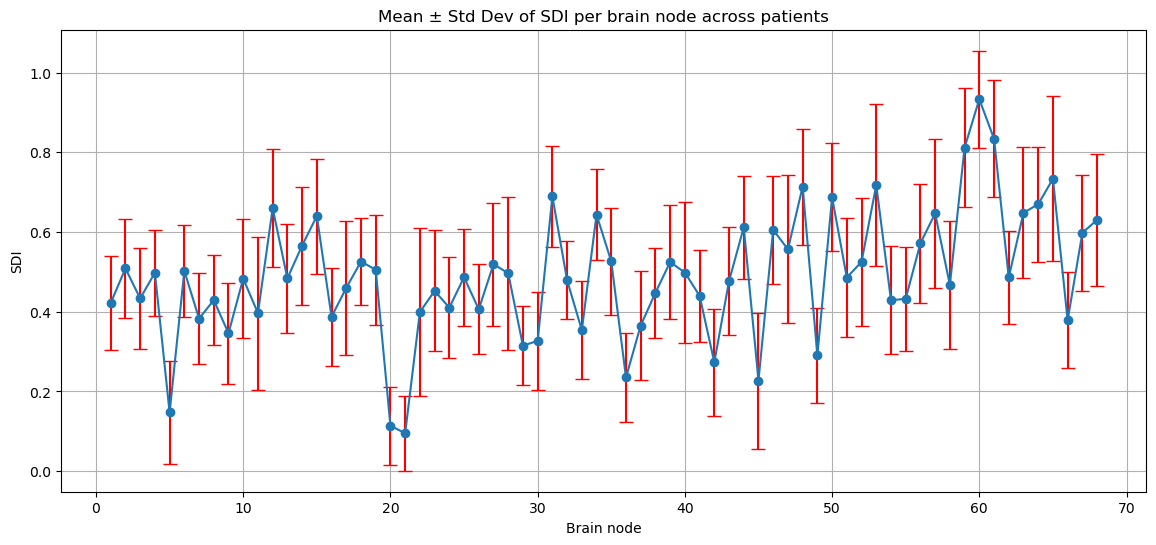

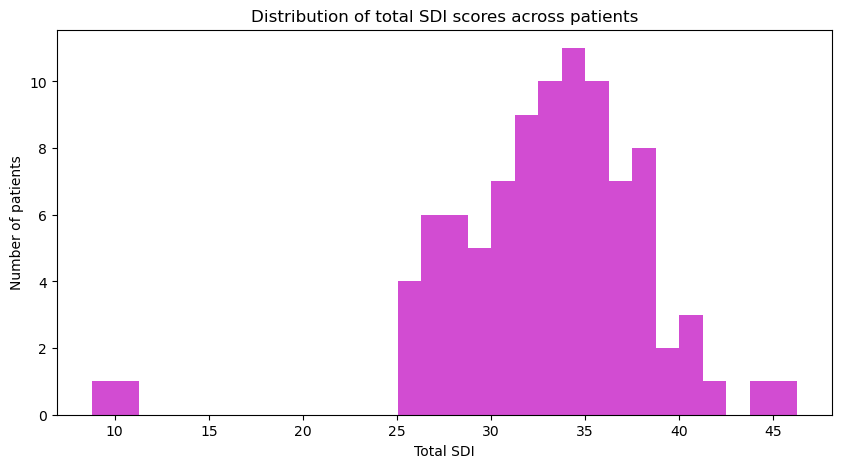

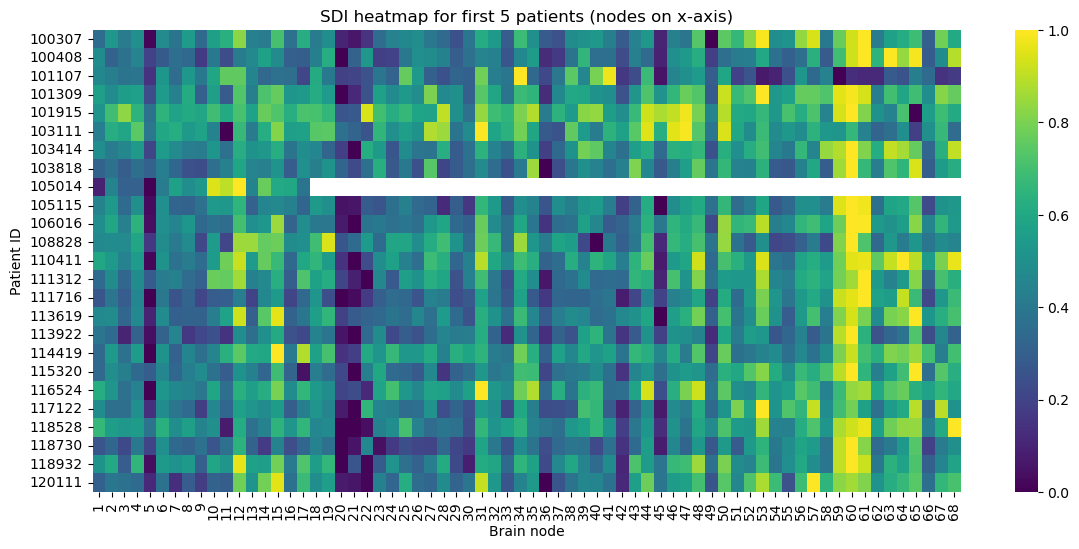

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# Path to your SDI results CSV
csv_path = "/Users/arnavkarnik/Documents/Classification/results/all_patients_SDI_informed_normalized_hcp.csv"

# Load SDI data from CSV (skip header)
patient_ids = []
sdi_data = []

with open(csv_path, 'r') as f:
    reader = csv.reader(f)
    header = next(reader)  # Skip header
    for row in reader:
        patient_ids.append(row[0])
        sdi_vals = [float(x) if x != '' else np.nan for x in row[1:]]
        sdi_data.append(sdi_vals)

sdi_array = np.array(sdi_data)  # shape: (num_patients, num_nodes)

# Replace empty/nan with np.nan explicitly
sdi_array = np.where(np.isnan(sdi_array), np.nan, sdi_array)

# Plot 1: Histogram of all SDI values across all nodes and patients
plt.figure(figsize=(12,6))
plt.hist(sdi_array[~np.isnan(sdi_array)].flatten(), bins=90, color='c', alpha=0.7)
plt.title("Histogram of all SDI values across all nodes and patients")
plt.xlabel("SDI value")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Mean ± Std Dev of SDI per brain node across patients
mean_sdi = np.nanmean(sdi_array, axis=0)
std_sdi = np.nanstd(sdi_array, axis=0)
nodes = np.arange(1, len(mean_sdi)+1)

plt.figure(figsize=(14,6))
plt.errorbar(nodes, mean_sdi, yerr=std_sdi, fmt='-o', ecolor='r', capsize=5)
plt.title("Mean ± Std Dev of SDI per brain node across patients")
plt.xlabel("Brain node")
plt.ylabel("SDI")
plt.grid(True)
plt.show()

# Plot 3: Distribution of total SDI per patient
total_sdi_per_patient = np.nansum(sdi_array, axis=1)

plt.figure(figsize=(10,5))
plt.hist(total_sdi_per_patient, bins=30, color='m', alpha=0.7)
plt.title("Distribution of total SDI scores across patients")
plt.xlabel("Total SDI")
plt.ylabel("Number of patients")
plt.show()

# Plot 4: Heatmap of SDI for first 5 patients (or less if fewer patients)
num_patients_to_show = min(25, sdi_array.shape[0])
plt.figure(figsize=(14,6))
sns.heatmap(sdi_array[:num_patients_to_show], cmap='viridis', xticklabels=np.arange(1, sdi_array.shape[1]+1), yticklabels=patient_ids[:num_patients_to_show])
plt.title("SDI heatmap for first 5 patients (nodes on x-axis)")
plt.xlabel("Brain node")
plt.ylabel("Patient ID")
plt.show()

In [13]:
import nibabel as nib
import numpy as np
from nilearn import plotting, datasets

# Load Desikan-Killiany atlas (volume)
atlas_path = '/Users/arnavkarnik/Documents/Classification/desikanKillianyMNI.nii.gz'
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# Load MNI152 background template
mni_template = datasets.load_mni152_template()

# Replace this with your actual SDI values (68 regions: 34 left + 34 right)
sdi_norm = np.random.rand(68)

# Create an empty volume with same shape as atlas
sdi_volume = np.zeros_like(atlas_data)

# Assign SDI values to voxels based on atlas labels (assumes labels 1–68 map to your SDI)
for label in range(1, 69):
    sdi_volume[atlas_data == label] = sdi_norm[label - 1]

# Create NIfTI image with mapped SDI values and same affine as atlas
sdi_img = nib.Nifti1Image(sdi_volume, affine=atlas_img.affine)

# Plot on MNI152 template
plotting.plot_stat_map(sdi_img, bg_img=mni_template,
                       title='SDI values on Desikan-Killiany atlas (MNI space)',
                       cmap='coolwarm', threshold=1e-5, colorbar=True)

plotting.show()


FileNotFoundError: No such file or no access: '/Users/arnavkarnik/Documents/Classification/desikanKillianyMNI.nii.gz'

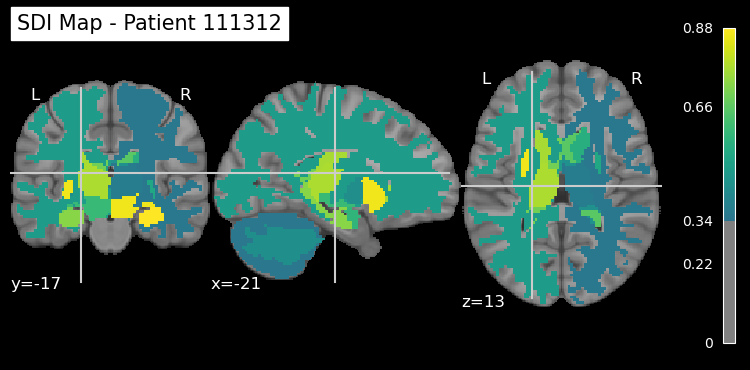

In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting, datasets

# -----------------------------
# Step 1: Load SDI from CSV
# -----------------------------
csv_path = "/Users/arnavkarnik/Documents/Classification/results/all_patients_SDI_informed_normalized.csv"  # ⬅️ Replace with actual path
patient_id = "111312"                    # ⬅️ Replace with desired patient ID

df = pd.read_csv(csv_path)
df["PatientID"] = df["PatientID"].astype(str)
row_match = df[df["PatientID"] == patient_id]

if row_match.empty:
    raise ValueError(f"Patient ID {patient_id} not found in CSV.")

sdi_row = row_match.iloc[0]
sdi_values = sdi_row.iloc[1:69].to_numpy(dtype=float)  # 68 cortical regions

# -----------------------------
# Step 2: Load DK atlas volume
# -----------------------------
atlas_path = "/Users/arnavkarnik/Documents/Classification/desikanKillianyMNI.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata()

# -----------------------------
# Step 3: Build SDI volume
# -----------------------------
sdi_volume = np.zeros_like(atlas_data)

# DK atlas labels start from 1 to 68 (assuming no subcortical in use)
for i in range(68):
    region_label = i + 1  # 1-based index
    sdi_volume[atlas_data == region_label] = sdi_values[i]

sdi_img = nib.Nifti1Image(sdi_volume, affine=atlas_img.affine)

# -----------------------------
# Step 4: Plot on MNI template
# -----------------------------
template = datasets.load_mni152_template()

display = plotting.plot_stat_map(
    sdi_img,
    bg_img=template,
    title=f"SDI Map - Patient {patient_id}",
    display_mode="ortho",
    threshold=np.percentile(sdi_values, 20),  # show top 80%
    cmap="viridis",
)
plotting.show()


In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib

# Desikan-Killiany atlas region names (68 regions)
region_names = {
    1: "Caudal middle frontal (LH)", 2: "Caudal middle frontal (RH)",
    3: "Frontal pole (LH)", 4: "Frontal pole (RH)",
    5: "Lateral orbitofrontal (LH)", 6: "Lateral orbitofrontal (RH)",
    7: "Medial orbitofrontal (LH)", 8: "Medial orbitofrontal (RH)",
    9: "Pars opercularis (LH)", 10: "Pars opercularis (RH)",
    11: "Pars orbitalis (LH)", 12: "Pars orbitalis (RH)",
    13: "Pars triangularis (LH)", 14: "Pars triangularis (RH)",
    15: "Rostral middle frontal (LH)", 16: "Rostral middle frontal (RH)",
    17: "Superior frontal (LH)", 18: "Superior frontal (RH)",
    19: "Precentral gyrus (LH)", 20: "Precentral gyrus (RH)",
    21: "Caudal anterior cingulate (LH)", 22: "Caudal anterior cingulate (RH)",
    23: "Rostral anterior cingulate (LH)", 24: "Rostral anterior cingulate (RH)",
    25: "Isthmus cingulate (LH)", 26: "Isthmus cingulate (RH)",
    27: "Insula (LH)", 28: "Insula (RH)",
    29: "Parahippocampal (LH)", 30: "Parahippocampal (RH)",
    31: "Posterior cingulate (LH)", 32: "Posterior cingulate (RH)",
    33: "Bankssts (LH)", 34: "Bankssts (RH)",
    35: "Entorhinal (LH)", 36: "Entorhinal (RH)",
    37: "Inferior temporal (LH)", 38: "Inferior temporal (RH)",
    39: "Middle temporal (LH)", 40: "Middle temporal (RH)",
    41: "Superior temporal (LH)", 42: "Superior temporal (RH)",
    43: "Temporal pole (LH)", 44: "Temporal pole (RH)",
    45: "Transverse temporal (LH)", 46: "Transverse temporal (RH)",
    47: "Inferior parietal (LH)", 48: "Inferior parietal (RH)",
    49: "Paracentral (LH)", 50: "Paracentral (RH)",
    51: "Postcentral (LH)", 52: "Postcentral (RH)",
    53: "Precuneus (LH)", 54: "Precuneus (RH)",
    55: "Superior parietal (LH)", 56: "Superior parietal (RH)",
    57: "Supramarginal (LH)", 58: "Supramarginal (RH)",
    59: "Pericalcarine (LH)", 60: "Pericalcarine (RH)",
    61: "Fusiform (LH)", 62: "Fusiform (RH)",
    63: "Cuneus (LH)", 64: "Cuneus (RH)",
    65: "Lateral occipital (LH)", 66: "Lateral occipital (RH)",
    67: "Lingual (LH)", 68: "Lingual (RH)"
}


# -------- Step 1: Load SDI values from CSV --------
csv_path = "SDI_results/all_patients_SDI_informed_normalized.csv"
patient_id = "100307"

df = pd.read_csv(csv_path)
df["PatientID"] = df["PatientID"].astype(str)
row = df[df["PatientID"] == patient_id]

if row.empty:
    raise ValueError(f"Patient {patient_id} not found in CSV")

# Extract exactly 68 SDI values (first 68 columns after PatientID)
sdi_values = row.iloc[0, 1:69].to_numpy(dtype=float)

# -------- Step 2: Load the Desikan-Killiany atlas --------
atlas_path = "/Users/arnavkarnik/Documents/Classification/desikanKillianyMNI.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata().astype(int)

# -------- Step 3: Identify top N coupled/decoupled regions --------
N = 10
top_indices = np.argsort(sdi_values)[-N:][::-1]
bottom_indices = np.argsort(sdi_values)[:N]

# -------- Step 4: Print with region names --------
print("Top Coupled Regions (High SDI):")
for i in top_indices:
    region_id = i + 1
    region_name = region_names.get(region_id, f"Unknown region {region_id}")
    print(f"Region {region_id} ({region_name}) — SDI: {sdi_values[i]:.4f}")

print("\nTop Decoupled Regions (Low SDI):")
for i in bottom_indices:
    region_id = i + 1
    region_name = region_names.get(region_id, f"Unknown region {region_id}")
    print(f"Region {region_id} ({region_name}) — SDI: {sdi_values[i]:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'SDI_results/all_patients_SDI_informed_normalized.csv'

Top Coupled Regions (High SDI):
Region 61 (Fusiform (LH)) — SDI: 1.0000
Region 53 (Precuneus (LH)) — SDI: 0.9896
Region 57 (Supramarginal (LH)) — SDI: 0.9394
Region 60 (Pericalcarine (RH)) — SDI: 0.9282
Region 56 (Superior parietal (RH)) — SDI: 0.8386
Region 12 (Pars orbitalis (RH)) — SDI: 0.8269
Region 52 (Postcentral (RH)) — SDI: 0.8245
Region 67 (Lingual (LH)) — SDI: 0.7813
Region 59 (Pericalcarine (LH)) — SDI: 0.7677
Region 50 (Paracentral (RH)) — SDI: 0.7499

Top Decoupled Regions (Low SDI):
Region 49 (Paracentral (LH)) — SDI: 0.0000
Region 5 (Lateral orbitofrontal (LH)) — SDI: 0.0128
Region 21 (Caudal anterior cingulate (LH)) — SDI: 0.0619
Region 20 (Precentral gyrus (RH)) — SDI: 0.1007
Region 45 (Transverse temporal (LH)) — SDI: 0.1013
Region 22 (Caudal anterior cingulate (RH)) — SDI: 0.1512
Region 29 (Parahippocampal (LH)) — SDI: 0.2475
Region 37 (Inferior temporal (LH)) — SDI: 0.2517
Region 42 (Superior temporal (RH)) — SDI: 0.2817
Region 36 (Entorhinal (RH)) — SDI: 0.2842


/var/folders/0b/d5vghlcn39jb_kt0c4whkzcr0000gn/T/ipykernel_3740/2324675303.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm', 3)  # 3 discrete colors: 0-bg, 1-red, 2-blue


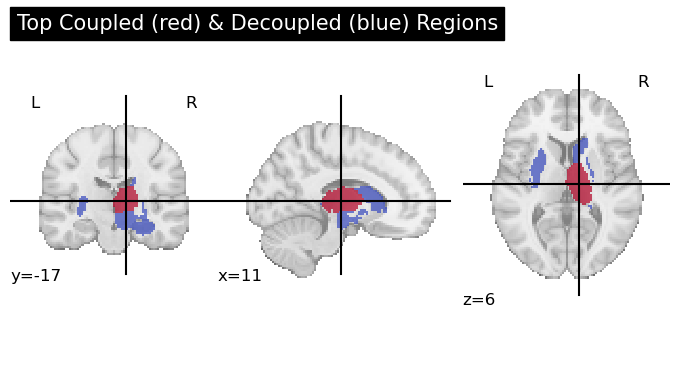

In [ ]:
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import plotting
import matplotlib.pyplot as plt

# Dictionary: Desikan-Killiany atlas region ID -> region name
region_names = {
    1: "Caudal middle frontal (LH)", 2: "Caudal middle frontal (RH)",
    3: "Frontal pole (LH)", 4: "Frontal pole (RH)",
    5: "Lateral orbitofrontal (LH)", 6: "Lateral orbitofrontal (RH)",
    7: "Medial orbitofrontal (LH)", 8: "Medial orbitofrontal (RH)",
    9: "Pars opercularis (LH)", 10: "Pars opercularis (RH)",
    11: "Pars orbitalis (LH)", 12: "Pars orbitalis (RH)",
    13: "Pars triangularis (LH)", 14: "Pars triangularis (RH)",
    15: "Rostral middle frontal (LH)", 16: "Rostral middle frontal (RH)",
    17: "Superior frontal (LH)", 18: "Superior frontal (RH)",
    19: "Precentral gyrus (LH)", 20: "Precentral gyrus (RH)",
    21: "Caudal anterior cingulate (LH)", 22: "Caudal anterior cingulate (RH)",
    23: "Rostral anterior cingulate (LH)", 24: "Rostral anterior cingulate (RH)",
    25: "Isthmus cingulate (LH)", 26: "Isthmus cingulate (RH)",
    27: "Insula (LH)", 28: "Insula (RH)",
    29: "Parahippocampal (LH)", 30: "Parahippocampal (RH)",
    31: "Posterior cingulate (LH)", 32: "Posterior cingulate (RH)",
    33: "Bankssts (LH)", 34: "Bankssts (RH)",
    35: "Entorhinal (LH)", 36: "Entorhinal (RH)",
    37: "Inferior temporal (LH)", 38: "Inferior temporal (RH)",
    39: "Middle temporal (LH)", 40: "Middle temporal (RH)",
    41: "Superior temporal (LH)", 42: "Superior temporal (RH)",
    43: "Temporal pole (LH)", 44: "Temporal pole (RH)",
    45: "Transverse temporal (LH)", 46: "Transverse temporal (RH)",
    47: "Inferior parietal (LH)", 48: "Inferior parietal (RH)",
    49: "Paracentral (LH)", 50: "Paracentral (RH)",
    51: "Postcentral (LH)", 52: "Postcentral (RH)",
    53: "Precuneus (LH)", 54: "Precuneus (RH)",
    55: "Superior parietal (LH)", 56: "Superior parietal (RH)",
    57: "Supramarginal (LH)", 58: "Supramarginal (RH)",
    59: "Pericalcarine (LH)", 60: "Pericalcarine (RH)",
    61: "Fusiform (LH)", 62: "Fusiform (RH)",
    63: "Cuneus (LH)", 64: "Cuneus (RH)",
    65: "Lateral occipital (LH)", 66: "Lateral occipital (RH)",
    67: "Lingual (LH)", 68: "Lingual (RH)"
}


# -------- Step 1: Load SDI values from CSV --------
csv_path = "SDI_results/all_patients_SDI_informed_normalized.csv"
patient_id = "100307"

df = pd.read_csv(csv_path)
df["PatientID"] = df["PatientID"].astype(str)
row = df[df["PatientID"] == patient_id]

if row.empty:
    raise ValueError(f"Patient {patient_id} not found in CSV")

sdi_values = row.iloc[0, 1:401].to_numpy(dtype=float)  # 400 regions

# -------- Step 2: Load the Desikan-Killiany atlas --------
atlas_path = "/Users/arnavkarnik/Documents/Classification/desikanKillianyMNI.nii.gz"
atlas_img = nib.load(atlas_path)
atlas_data = atlas_img.get_fdata().astype(int)

# -------- Step 3: Identify top N coupled/decoupled regions --------
N = 10
top_indices = np.argsort(sdi_values)[-N:][::-1]
bottom_indices = np.argsort(sdi_values)[:N]

# -------- Step 4: Print with region names --------
print("Top Coupled Regions (High SDI):")
for i in top_indices:
    region_id = i + 1
    region_name = region_names.get(region_id, f"Unknown region {region_id}")
    print(f"Region {region_id} ({region_name}) — SDI: {sdi_values[i]:.4f}")

print("\nTop Decoupled Regions (Low SDI):")
for i in bottom_indices:
    region_id = i + 1
    region_name = region_names.get(region_id, f"Unknown region {region_id}")
    print(f"Region {region_id} ({region_name}) — SDI: {sdi_values[i]:.4f}")

# -------- Step 5: Create masks for visualization --------
top_mask = np.isin(atlas_data, [i + 1 for i in top_indices])
bottom_mask = np.isin(atlas_data, [i + 1 for i in bottom_indices])

# Create combined mask:
# 0 = background, 1 = top coupled (red), 2 = top decoupled (blue)
combined_mask = np.zeros(atlas_data.shape, dtype=np.uint8)
combined_mask[top_mask] = 1
combined_mask[bottom_mask] = 2

combined_img = nib.Nifti1Image(combined_mask, affine=atlas_img.affine)

# -------- Step 6: Plot --------
cmap = plt.cm.get_cmap('coolwarm', 3)  # 3 discrete colors: 0-bg, 1-red, 2-blue

display = plotting.plot_roi(combined_img,
                            title="Top Coupled (red) & Decoupled (blue) Regions",
                            cmap=cmap,
                            alpha=0.7)

plt.show()
